## Problem Statement 

We build a model that is able to classify customer complaints based on the products/services. we segregated these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

we did topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we applied NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## METHODS PERFORMED:

You need to perform the following eight major tasks to complete the assignment:

1.  Data Reading

2. Data cleaning

3. Data presprocessing

4. Data Visualization

5. Feature extraction

6. Topic modelling 

7. Model building 

   i)logistic Regression
   
   ii)Decision Trees
   
   iii)Random Forest


8. Model inference

# DATA READING

### Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from nltk.util import ngrams 
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
from pprint import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

### Loading the data

The data is in JSON format and we converted it to a dataframe.

In [2]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)#loading the data
df=pd.json_normalize(data)#normalizing it

In [3]:
#displaying first two rows
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [4]:
# Inspecting the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

# DATA CLEANING

In [5]:
#printing the column names
print("The column names are: ", df.columns.values)

The column names are:  ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [6]:
#Assigning new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [7]:
#Assigning nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)
print("No. of rows with nan in complaints column: ", df.complaint_what_happened.isnull().sum())

No. of rows with nan in complaints column:  57241


In [8]:
#Removing all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

# DATA PREPROCESSING

### Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* converting into lower case
* Removing text inside square brackets
* Removing punctuation
* Removing words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatizing the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# function to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text=text.lower()  #convert to lower case
  text=re.sub(r'^\[[\w\s]\]+$',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'^[a-zA-Z]\d+\w*$',' ',text) #Remove words with numbers
  return text

In [10]:
#checking a sample complaint whethwe it has removed unneccessary elements
sample = df.complaint_what_happened.sample().values[0]
print(sample)
print("******************************")
cleanSample = clean_text(sample)
print(cleanSample)

On XX/XX/XXXX my checking and saving accounts were both restricted for an unknown reason, and the customer service from the fraud department told me that they can't disclose any information about why my account was restricted, but my account will be closed in a week and the check will be mailed out. However, On XX/XX/XXXX, when I called the fraud department again, they told the check can't be mailed out, because they realize that there are two unknown sources of direct deposit coming into my checking account for the name under my husband and my son, and that was the reason they can't mail out my check for the remaining balance of {$5000.00} ( checking ) and {$390.00} ( saving ) even the account has already been closed, and he told me on the phone that all three of us must go down to the branch and meet with a personal banker with two forms of ID. We did go down to the branch on XX/XX/XXXX and show our two forms of ID to officer relationship banker XXXX XXXX  XXXX ( NMSL ID:XXXX ), then

In [11]:
#function to Lemmatize the texts
def lemmatize_text(text):
  sentence = []
  doc = nlp(text)
  for word in doc:
    sentence.append(word.lemma_)

  return " ".join(sentence)

In [12]:
#taking a sample and lemmatizing it
print(cleanSample)
print("*****************************")
lemmatizedText =lemmatize_text(cleanSample)
print(lemmatizedText)

on xx xx xxxx my checking and saving accounts were both restricted for an unknown reason  and the customer service from the fraud department told me that they can t disclose any information about why my account was restricted  but my account will be closed in a week and the check will be mailed out  however  on xx xx xxxx  when i called the fraud department again  they told the check can t be mailed out  because they realize that there are two unknown sources of direct deposit coming into my checking account for the name under my husband and my son  and that was the reason they can t mail out my check for the remaining balance of   5000 00    checking   and   390 00    saving   even the account has already been closed  and he told me on the phone that all three of us must go down to the branch and meet with a personal banker with two forms of id  we did go down to the branch on xx xx xxxx and show our two forms of id to officer relationship banker xxxx xxxx  xxxx   nmsl id xxxx    then

In [13]:
#Creating a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=pd.DataFrame()

In [14]:
df_clean['complaint'] = df['complaint_what_happened'].progress_apply(clean_text)

100%|██████████| 21072/21072 [00:03<00:00, 6547.43it/s]


In [15]:
df_clean['lemmatized_complaint'] = df_clean['complaint'].progress_apply(lemmatize_text)

100%|██████████| 21072/21072 [26:41<00:00, 13.15it/s] 


In [16]:
df_clean.head(2)

,complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,I upgrade my xxxx xxxx card in xx xx 2018 and ...


In [17]:
df_clean.shape

(21072, 2)

In [18]:
#function to extract the POS tags 
def get_pos_tag(text):
  return pos_tag(word_tokenize(text))

def get_NN(text):
  NN = []
  wordsWithTags = get_pos_tag(text)
  for word, tag in wordsWithTags:
    if (tag == 'NN'):
      NN.append(word)
  
  return " ".join(NN)

In [19]:
#importing some neccesary nltk libraries
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bonth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bonth\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
#this column contains lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaint'].progress_apply(get_NN)

100%|██████████| 21072/21072 [05:54<00:00, 59.37it/s] 


In [21]:
#The clean dataframe contains the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,I upgrade my xxxx xxxx card in xx xx 2018 and ...,card xx agent upgrade date agent information o...
10,chase card was reported on xx xx 2019 however...,chase card be report on xx xx 2019 however ...,card xx application identity consent service c...
11,on xx xx 2018 while trying to book a xxxx xx...,on xx xx 2018 while try to book a xxxx xxx...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for 1600 00 i de...,my grand son give I check for 1600 00 I d...,son chase account fund bank account pay money ...


# DATA VISUALISATION

### Exploratory data analysis to get familiar with the data.



*   Visualising the data according to the 'Complaint' character length
*   performing word cloud,finding the top 40 words by frequency among all the articles after processing the text
*   calculating the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<AxesSubplot:xlabel='complaint charecter length', ylabel='Frequency'>

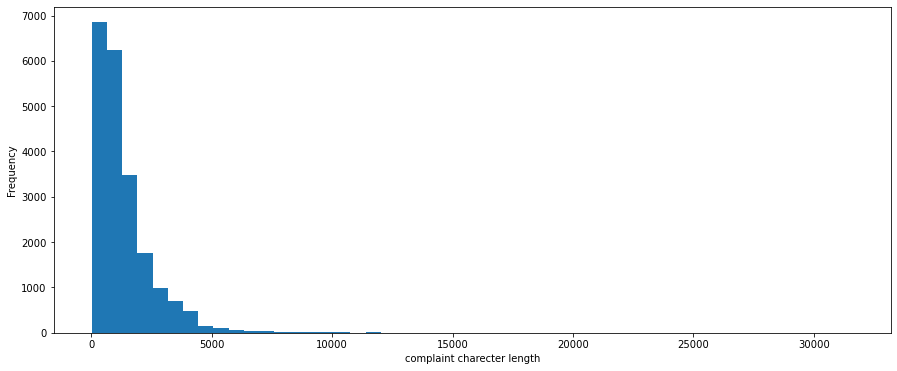

In [22]:
# visualising the data according to the 'Complaint' character length
plt.xlabel("complaint charecter length")
plt.ylabel("No of complaints")
df_clean['complaint'].str.len().plot(kind='hist', bins=50,figsize=(15,6))

#### Find the top 40 words by frequency among all the articles after processing the text.

In [23]:
#installing the word cloud
!pip install wordcloud
from wordcloud import WordCloud

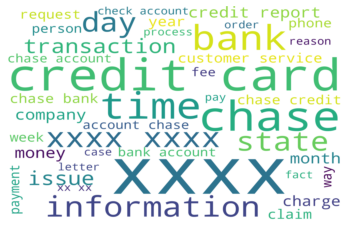

In [24]:
#Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
stopwords=nlp.Defaults.stop_words
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [26]:
#checking the shape
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [27]:
#finding the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [28]:
#Printing the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'frequency'])
df_unigram.head(10)

,unigram,frequency
0,chase,47759
1,account,47666
2,xxxx,41161
3,credit,34311
4,card,29375
5,bank,28530
6,payment,21366
7,time,16281
8,charge,15142
9,day,13277


In [29]:
#finding the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [30]:
#Printing the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'frequency'])
df_bigram.head(10)

,bigram,frequency
0,credit card,12826
1,xxxx xxxx,5063
2,credit report,3963
3,customer service,3089
4,chase bank,3042
5,chase credit,3027
6,bank account,2713
7,account chase,2660
8,chase account,2637
9,check account,2580


In [31]:
#finding the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [32]:
#Printing the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'frequency'])
df_trigram.head(10)

,trigram,frequency
0,chase credit card,2116
1,credit card account,1023
2,credit card company,996
3,xxxx xxxx xxxx,766
4,credit card chase,658
5,credit card credit,514
6,inquiry credit report,480
7,charge credit card,419
8,account credit card,398
9,credit reporting agency,390


The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
#All masked texts has been removed
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [34]:
df_clean.head(2)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,I upgrade my xxxx xxxx card in xx xx 2018 and ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...


In [35]:
#storing a copy in df_cleaner
df_cleaner=df_clean.copy()

# FEATURE EXTRACTION


Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [36]:
#initialising the TfidfVectorizer 
tf_idf_vec=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Creating a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [37]:
# creating the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tf_idf_vec.fit_transform(df_clean['complaint_POS_removed'])

# TOPIC MODELLING

 

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this we performed the following:

* setting the best number of clusters to "5". 
* Applying the best number to create word clusters.
* validated the correction of each cluster wrt the complaints. 
* Corrected the labels.
* Mapped the clusters to topics/cluster names

In [38]:
from sklearn.decomposition import NMF

### Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model =NMF(n_components=num_topics,random_state=40)

In [40]:
nmf_model.fit(dtm)
len(tf_idf_vec.get_feature_names_out())

6942

In [41]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['transfer', 'xx', 'transaction', 'business', 'number', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['letter', 'year', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'xxxx', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['time', 'refund', 'xx', 'service', 'purchase', 'fraud', 'claim', 'merchant', 'fee', 'chase', 'transaction', 'dispute', 'xxxx', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['account', 'xx', 'chase', 'credit', 'date', 'pay', 'xxxx', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']




In [42]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)
topic_result.argmax(axis=1)


array([0, 3, 1, ..., 3, 4, 4], dtype=int64)

In [43]:
#Assigning the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_result.argmax(axis=1)

In [44]:
df_clean.shape

(21072, 5)

In [45]:
df_clean.head(2)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,I upgrade my xxxx xxxx card in xx xx 2018 and ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...,3


In [46]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
17,with out notice j p morgan chase restricted m...,with out notice j p morgan chase restrict my...,j p chase account debit card tuesday xx branch...,j p chase account debit card tuesday xx branch...,0
14,my grand son give me check for 1600 00 i de...,my grand son give I check for 1600 00 I d...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
10,chase card was reported on xx xx 2019 however...,chase card be report on xx xx 2019 however ...,card xx application identity consent service c...,card xx application identity consent service c...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
11,on xx xx 2018 while trying to book a xxxx xx...,on xx xx 2018 while try to book a xxxx xxx...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1


#### After evaluating the mapping, we assigned these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [47]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'  }


#Replacing the Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean.head(2)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,I upgrade my xxxx xxxx card in xx xx 2018 and ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...,Theft/Dispute Reporting


#### Supervised model to predict any new complaints to the relevant Topics.

we build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

we have converted the topic names to numbers(numpy arrays only understand numbers)

In [49]:
#Keep the columns"complaint" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint','Topic']]

In [50]:
training_data.head(2)

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,Theft/Dispute Reporting


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [51]:
#Write your code to get the Vector count
count_vect=CountVectorizer()
X_train_counts=count_vect.fit_transform(training_data['complaint'])

In [53]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)


# MODEL BUILDING

In [54]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40)

In [55]:
# function to evaluate the model (accuracy,F1-score,precision,Recall,heatmap,classification report) and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', accuracy_score(y_test,y_pred))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted'))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted'))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted'))
    print('Classification Report: ', classification_report(y_test,y_pred))
    plt.figure(figsize=(10,7))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

we used 3 models on the train & test data 
* Logistic regression
* Decision Tree
* Random Forest

### MODEL 1 - LOGISTIC REGRESSION

In [56]:
model_name = 'LOGISTIC REGRESSION'
#storing the logisticregression inside lr
lr = LogisticRegression() 
#fitting the model on train data
lr.fit(X_train, y_train)
#predicting on test data
y_pred_lr = lr.predict(X_test)

In [57]:
# writing the necessary parameters for logistic regression
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
#GridSearchCV is a technique to search through the best parameter values from the given set of the grid of parameters.
grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [58]:
# tuning the hyper-parameter for getting the best results
lr_tuned = LogisticRegression(C=1, penalty='l1',solver='saga')
lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [59]:
#calculating the F1 score for logistic regression
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9404716642127063

THE F1-SCORE OF LOGISTIC REGRESSION IS 94%

Training results
Accuracy:  0.9404507710557533
Precision:  0.9405860934486034
Recall:  0.9404507710557533
F1 Score:  0.9404716642127063
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1015
Credit card or prepaid card       0.94      0.94      0.94       967
              Mortgage/Loan       0.95      0.93      0.94       455
                     Others       0.96      0.94      0.95       749
    Theft/Dispute Reporting       0.92      0.93      0.92      1029

                   accuracy                           0.94      4215
                  macro avg       0.94      0.94      0.94      4215
               weighted avg       0.94      0.94      0.94      4215



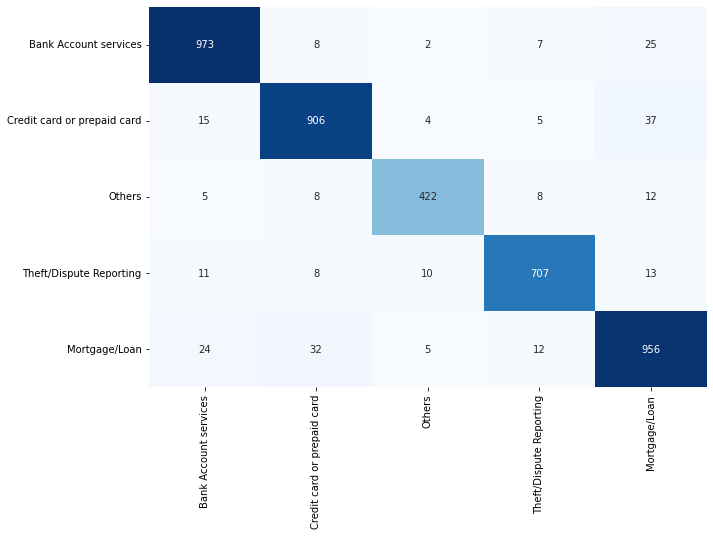

In [60]:
#calculating the overall score and classification report
eval_model(y_test, y_pred_lr_tuned, model_name)

### MODEL 2 - DECISION TREE

In [61]:
model_name = 'DECISION TREE'
#initializing the decisiontreeclassifier inside dt
dt = DecisionTreeClassifier()
#fitting the model on train data
dt.fit(X_train, y_train)
#predicting on test data
y_pred_dt =dt.predict(X_test)

In [62]:
# tuning the hyper-parameter for getting the best results
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 15}


In [63]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [64]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7901938057148487

THE F1-SCORE OF DECISSION TREE IS 78%

Training results
Accuracy:  0.9404507710557533
Precision:  0.9405860934486034
Recall:  0.9404507710557533
F1 Score:  0.9404716642127063
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1015
Credit card or prepaid card       0.94      0.94      0.94       967
              Mortgage/Loan       0.95      0.93      0.94       455
                     Others       0.96      0.94      0.95       749
    Theft/Dispute Reporting       0.92      0.93      0.92      1029

                   accuracy                           0.94      4215
                  macro avg       0.94      0.94      0.94      4215
               weighted avg       0.94      0.94      0.94      4215



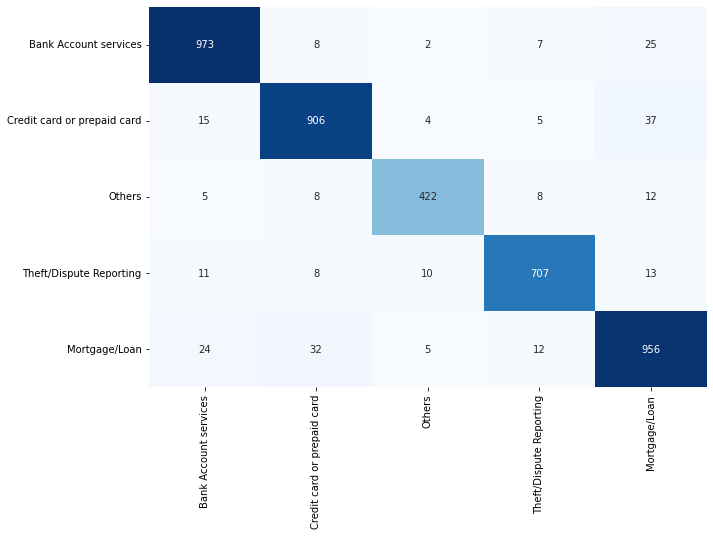

In [65]:
#calculating the overall score and classification report
eval_model(y_test, y_pred_lr_tuned, model_name)

### MODEL 3 - RANDOM FOREST

In [66]:
# running the random forest model with default parameters
model_name = 'RANDOM FOREST'
rfc = RandomForestClassifier(max_depth=10)
#fitting the model using train data
rfc.fit(X_train, y_train)
#predicting on test set
y_pred_rfc = rfc.predict(X_test)

In [67]:
# Calculate F1 Score of tuned model using weighted average method
f1_rfc = f1_score(y_test, y_pred_rfc, average="weighted")
f1_rfc

0.6840159059719041

THE F1-SCORE OF RANDOM FOREST IS 68%

Training results
Accuracy:  0.9404507710557533
Precision:  0.9405860934486034
Recall:  0.9404507710557533
F1 Score:  0.9404716642127063
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1015
Credit card or prepaid card       0.94      0.94      0.94       967
              Mortgage/Loan       0.95      0.93      0.94       455
                     Others       0.96      0.94      0.95       749
    Theft/Dispute Reporting       0.92      0.93      0.92      1029

                   accuracy                           0.94      4215
                  macro avg       0.94      0.94      0.94      4215
               weighted avg       0.94      0.94      0.94      4215



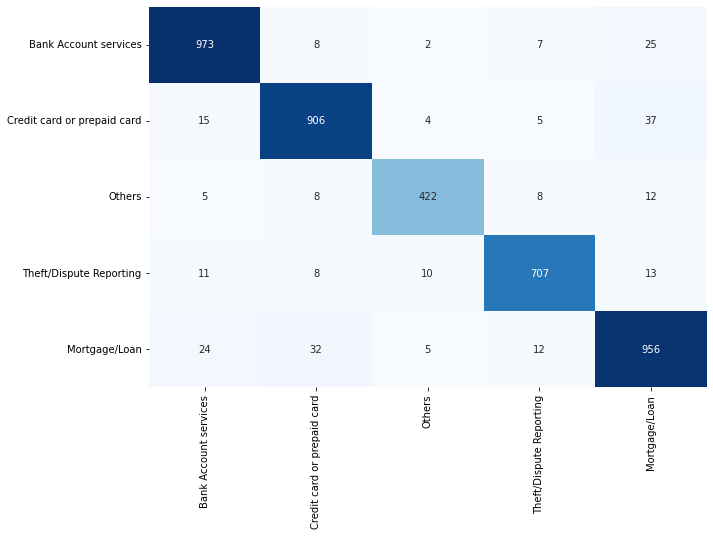

In [68]:
#calculating the overall score and classification report
eval_model(y_test, y_pred_lr_tuned, model_name)

we used three models which are logistic regression,decision tress,random forest-out of all these models logistic regression 
gives a good accuracy score of 94% so we use that model for inferencing on test data.

# MODEL INFERENCE

In [69]:
print(Topic_names)

{0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}


In [70]:
#taking a sample complaint for infering model
df_complaints = pd.DataFrame({'complaint': [
                                  "I received a fraudulent email about a merchant saying a dispute with me is open and requested some information.",
                                  "Last credit card report shown a duplicated charge. Please take a look into it.",
                                  "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "I want to open a bank account at the nearest location with initial funds. Please provide me the procedure.",
                                  "What are the different ways I can make payments?"]})
df_complaints

,complaint
0,I received a fraudulent email about a merchant...
1,Last credit card report shown a duplicated cha...
2,I can not get from chase who services my mortg...
3,I want to open a bank account at the nearest l...
4,What are the different ways I can make payments?


In [71]:
#function for predicting best model
def predict_best_model(text):
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr_tuned.predict(X_new_tfidf)
    return predicted[0]

In [72]:
#displaying complaint and respective topics as a tabular form
df_complaints['Topic'] = df_complaints['complaint'].apply(lambda x: predict_best_model([x]))
df_complaints

,complaint,Topic
0,I received a fraudulent email about a merchant...,Theft/Dispute Reporting
1,Last credit card report shown a duplicated cha...,Credit card or prepaid card
2,I can not get from chase who services my mortg...,Others
3,I want to open a bank account at the nearest l...,Bank Account services
4,What are the different ways I can make payments?,Mortgage/Loan


# Conclusion

Logistic Regression model sucessfully predicted the topics complaint sample. 
Therefore, our model efficiently classifies customer complaints.